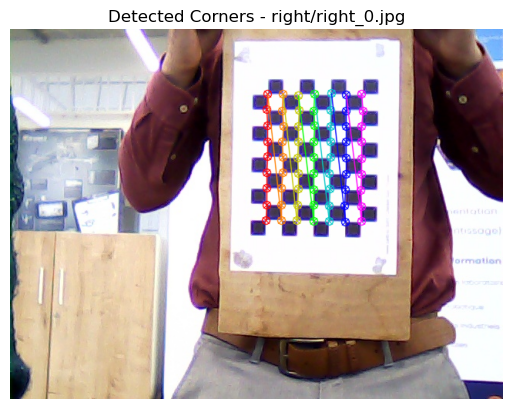

Saved: output_corners\right_0.jpg


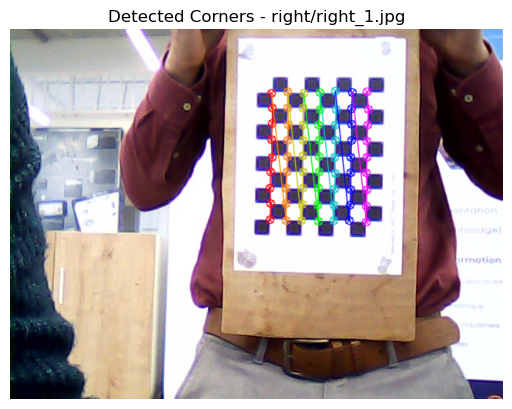

Saved: output_corners\right_1.jpg


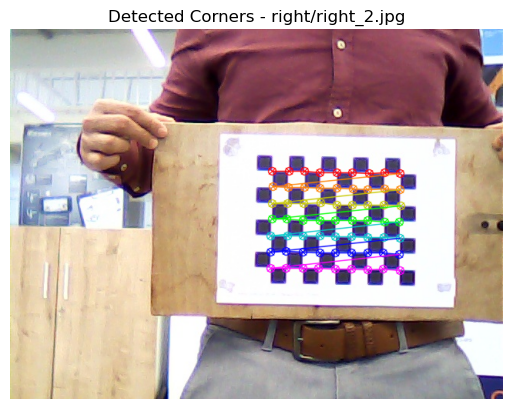

Saved: output_corners\right_2.jpg


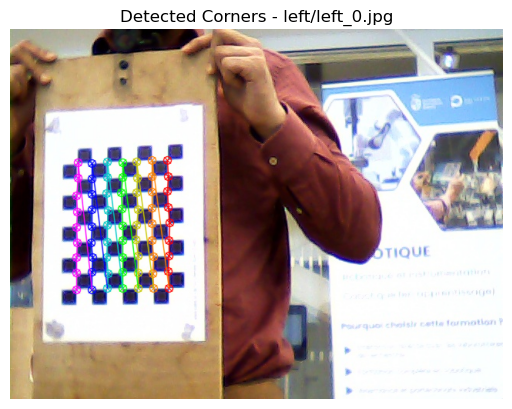

Saved: output_corners\left_0.jpg


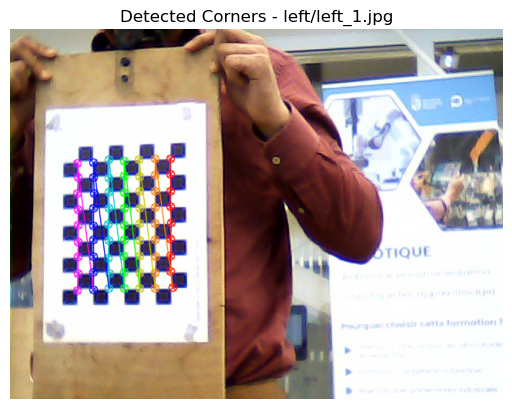

Saved: output_corners\left_1.jpg


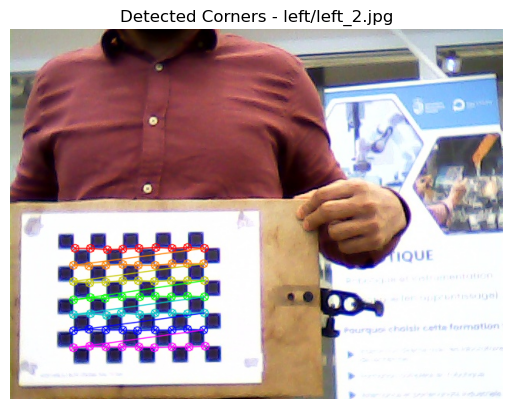

Saved: output_corners\left_2.jpg


In [38]:
 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Define chessboard size (Adjust if necessary)
chessboard_size = (9,7 )  # (Columns, Rows) - Change if needed
square_size = 1.0  # Set to 1.0 if unknown

# Prepare object points (3D points of chessboard corners in real-world)
objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2) * square_size

# Lists to store 3D points (object points) and 2D points (image points)
objpoints = []  # Real-world points
imgpoints = []  # Image points (detected corners)

# List of calibration images (PNG format)
image_paths = ["right/right_0.jpg","right/right_1.jpg","right/right_2.jpg","left/left_0.jpg","left/left_1.jpg","left/left_2.jpg"]

# Create a folder to save output images
output_folder = "output_corners"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Read and process each calibration image
for img_path in image_paths:
    img = cv2.imread(img_path)
    
    if img is None:
        print(f"Error: Could not load {img_path}")
        continue
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    
    # Detect chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)
    
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, chessboard_size, corners, ret)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected Corners - {img_path}")
        plt.axis("off")
        plt.show()

        # Save the output image with detected corners
        output_path = os.path.join(output_folder, os.path.basename(img_path))
        cv2.imwrite(output_path, img)
        print(f"Saved: {output_path}")
    else:
        print(f"Chessboard not detected in {img_path}")
  


In [40]:
# Performed camera calibration
if len(objpoints) > 0 and len(imgpoints) > 0:
    ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    print("Intrinsic Matrix (K):\n", K)
    print("\nDistortion Coefficients:\n", dist)

    # Computed reprojection error
    reprojection_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], K, dist)
        error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
        reprojection_error += error
    reprojection_error /= len(objpoints)

    print("\nReprojection Error:", reprojection_error)

else:
    print("Calibration failed: No valid chessboard detections.")


Intrinsic Matrix (K):
 [[2.02000903e+03 0.00000000e+00 2.91857478e+02]
 [0.00000000e+00 1.99604747e+03 1.84051507e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion Coefficients:
 [[-1.37466838e+00  1.30448239e+02  4.93230830e-03  7.08938060e-03
  -3.39547959e+03]]

Reprojection Error: 0.11086367915593026


# 3. Undistort Images

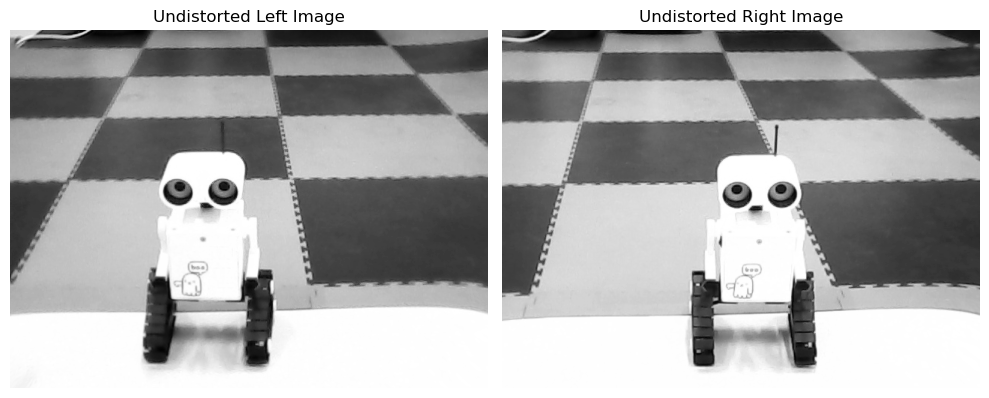

Undistorted images saved to: undistorted_output


In [43]:

# Define paths
input_left_path = "left/left_5.jpg"
input_right_path = "right/right_5.jpg"
output_folder = "undistorted_output"

# Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Load left and right images
left_img = cv2.imread("left/left_5.jpg")
right_img = cv2.imread("right/right_5.jpg")

# Check if images are loaded successfully
if left_img is None or right_img is None:
    raise FileNotFoundError("One or both images could not be loaded. Check the file paths.")

# Convert images to grayscale
left_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
right_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

# Undistort images using camera matrix (K) and distortion coefficients (dist)
undistorted_left = cv2.undistort(left_gray, K, dist)
undistorted_right = cv2.undistort(right_gray, K, dist)

# Save undistorted images to the output folder
output_left_path = os.path.join(output_folder, "undistorted_left.jpg")
output_right_path = os.path.join(output_folder, "undistorted_right.jpg")
cv2.imwrite(output_left_path, undistorted_left)
cv2.imwrite(output_right_path, undistorted_right)

# Display the undistorted images side by side
plt.figure(figsize=(10, 5))

# Display left undistorted image
plt.subplot(1, 2, 1)
plt.imshow(undistorted_left, cmap="gray")
plt.title("Undistorted Left Image")
plt.axis("off")

# Display right undistorted image
plt.subplot(1, 2, 2)
plt.imshow(undistorted_right, cmap="gray")
plt.title("Undistorted Right Image")
plt.axis("off")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

print(f"Undistorted images saved to: {output_folder}")

# 4. Feature Matching using SIFT

Total number of matching features: 95
Feature matching image saved as sift_matches.png


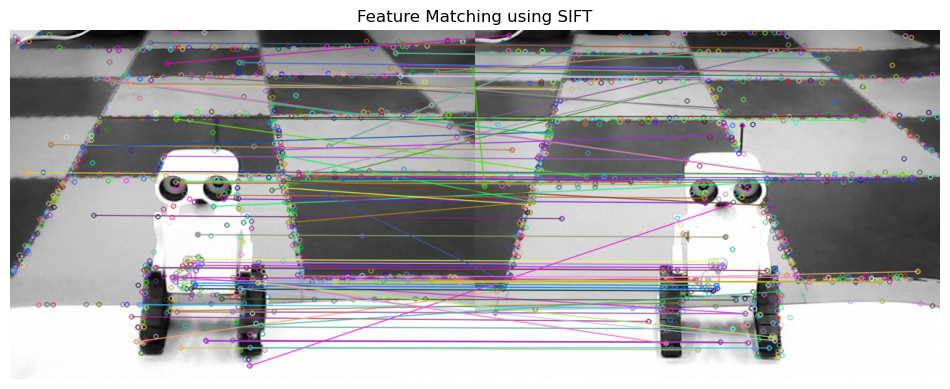

In [46]:

# Detect and compute SIFT keypoints
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(undistorted_left, None)
kp2, des2 = sift.detectAndCompute(undistorted_right, None)

# Feature Matching using FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Apply Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Print the total number of matching features
total_matches = len(good_matches)
print(f"Total number of matching features: {total_matches}")

# Draw matches
matched_img = cv2.drawMatches(undistorted_left, kp1, undistorted_right, kp2, good_matches, None)

# Save the output image
output_path = "sift_matches.png"
cv2.imwrite(output_path, matched_img)
print(f"Feature matching image saved as {output_path}")

# Show matched features
plt.figure(figsize=(12, 6))
plt.imshow(matched_img)
plt.title("Feature Matching using SIFT")
plt.axis("off")
plt.show()

In [48]:
# Extract matched keypoints
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

# Compute Fundamental Matrix with RANSAC
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

print("Fundamental Matrix (F):\n", F)


Fundamental Matrix (F):
 [[ 3.39869648e-07 -3.34753576e-05  1.12836865e-02]
 [ 5.60679829e-05  1.61429645e-05  2.69091989e-01]
 [-1.64198253e-02 -2.82304164e-01  1.00000000e+00]]


In [50]:
# Compute Essential Matrix
E, _ = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC)

# Recover the Camera Pose
_, R, t, _ = cv2.recoverPose(E, pts1, pts2, K)

print("Essential Matrix (E):\n", E)
print("\nRotation Matrix (R):\n", R)
print("\nTranslation Vector (t):\n", t)


Essential Matrix (E):
 [[ 0.00085245  0.07472265  0.01042612]
 [ 0.01666155 -0.0031118   0.70683043]
 [-0.00574967 -0.7031173  -0.00188408]]

Rotation Matrix (R):
 [[ 0.99160678  0.00670333 -0.12911648]
 [-0.00616771  0.99997064  0.00454773]
 [ 0.12914317 -0.0037132   0.99161901]]

Translation Vector (t):
 [[ 0.9942908 ]
 [-0.01438449]
 [ 0.1057303 ]]
